# Language Classifier

In [142]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential,models,preprocessing
from keras.layers import Dense,Embedding, Flatten
import numpy as np 
import pandas as pd 

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords 
stop = stopwords.words('english')

import warnings
warnings.filterwarnings("ignore")

In [149]:
#! pip install Wikipedia

In [3]:
tf.__version__

'1.14.0'

In [107]:
train = pd.read_csv('datasets/train_languages.csv')

In [108]:
train.head()

,sentence,language
0,"Jean Beauverie (Fontaines-sur-Saône, 18 febbra...",italian
1,Il pinguino saltarocce (Eudyptes chrysocome (F...,italian
2,Maison Ikkoku - Cara dolce Kyoko (めぞん一刻 Mezon ...,italian
3,La mia città è un singolo della cantante itali...,italian
4,L'Armata Rossa dei Lavoratori e dei Contadini ...,italian


In [109]:
train.shape

(3633, 2)

In [110]:
X = train[["sentence"]]
y = train["language"]

In [111]:
# Encode languages as numerical and then create one-hot encoding representation
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y = keras.utils.to_categorical(y,num_classes=4)

In [112]:
train['sentence_lower'] = train["sentence"].str.lower()
train['sentence_no_punctuation'] = train['sentence_lower'].str.replace('[^\w\s]','')
train['sentence_no_punctuation'] = train["sentence_no_punctuation"].fillna("fillna")

In [113]:
# Set parameters of max features and the length of the embedding, tokenize, get the length of the word index and add one
# due to python indexing to get the length of the vocabulary
max_features=5000 
maxlen=400 

tok = tf.keras.preprocessing.text.Tokenizer(num_words=max_features)
tok.fit_on_texts(list(train['sentence_no_punctuation']))

print(len(tok.word_index))
vocab_size = len(tok.word_index) + 1 

51630


In [114]:
# Convert the tokenized sentences to a sequence and pad the sequence to equal length
train_df = tok.texts_to_sequences(list(train['sentence_no_punctuation'])) 
train_df = tf.keras.preprocessing.sequence.pad_sequences(train_df, maxlen=maxlen)

In [116]:
# Create the training and test sets as 90 to 10 split
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.1, random_state=42)

In [117]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3269, 400) (364, 400) (3269, 4) (364, 4)


In [128]:
# Embedding dimension size and create the model
embedding_dim = 50

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,input_length=maxlen))
model.add(Flatten()),
model.add(Dense(4,activation="softmax"))
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 50)           2581550   
_________________________________________________________________
flatten_1 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 80004     
Total params: 2,661,554
Trainable params: 2,661,554
Non-trainable params: 0
_________________________________________________________________


In [129]:
model.fit(np.array(X_train), np.array(y_train), epochs=3)


Epoch 1/3
3269/3269 [==============================] - 5s 2ms/step - loss: 0.8193 - accuracy: 0.7323
Epoch 2/3
3269/3269 [==============================] - 6s 2ms/step - loss: 0.0781 - accuracy: 0.9966
Epoch 3/3
3269/3269 [==============================] - 5s 2ms/step - loss: 0.0260 - accuracy: 0.9976


In [130]:
model.evaluate(np.array(X_test), np.array(y_test)) 

364/364 [==============================] - 0s 356us/step


[0.012854333926033188, 1.0]

In [132]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_pred.argmax(axis=1), y_test.argmax(axis=1))

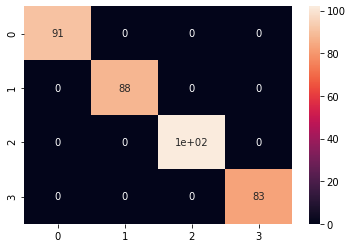

In [138]:
sns.heatmap(cm, annot= True)
plt.show()

In [139]:
print('english', encoder.transform(['english']))
print('french', encoder.transform(['french']))
print('italian', encoder.transform(['italian']))
print('spanish', encoder.transform(['spanish']))

english [0]
french [1]
italian [2]
spanish [3]


In [140]:
#new_text = ["tensorflow is a great tool you can find a lot of tutorials from packt"]
new_text = ["tensorflow est un excellent outil vous pouvez trouver beaucoup de tutoriels de packt"]
#new_text = ["tensorflow è un ottimo strumento puoi trovare molti tutorial di packt"]
#new_text = ["tensorflow es una gran herramienta puedes encontrar muchos tutoriales de packt"]

In [143]:
test_text = tok.texts_to_sequences(new_text) 
test_text = preprocessing.sequence.pad_sequences(test_text, maxlen=maxlen)

In [144]:
np.set_printoptions(suppress=True)
predictions = model.predict(test_text)
print(predictions.argmax())
print(predictions)

1
[[0.02591038 0.6578947  0.11632952 0.19986543]]


In [150]:
import wikipedia

#english: en
#italian: it
#french: fr
#spanish: es

new_wiki_text = []
wikipedia.set_lang('it')
for i in range(0, 5):
    print(i)
    random = wikipedia.random(1)
       
    try:
        new_wiki_text.append([wikipedia.page(random).summary])
    except wikipedia.exceptions.DisambiguationError as e:
        random = wikipedia.random(1)

0
1
2
3
4


In [151]:
new_wiki_text = pd.DataFrame(new_wiki_text)
new_wiki_text.columns = ['sentence']
new_wiki_text

,sentence
0,"Giovanni Grasso (Roma, 14 ottobre 1962) è un g..."
1,La storia degli ebrei in Scozia risale almeno ...
2,"James Beaumont Neilson (Shettleston, 22 giugno..."
3,Il Duca di Genova è stato un incrociatore ausi...


In [152]:
new_wiki_text['sentence_lower'] = new_wiki_text["sentence"].str.lower()
new_wiki_text['sentence_no_punctuation'] = new_wiki_text['sentence_lower'].str.replace('[^\w\s]','')
new_wiki_text['sentence_no_punctuation'] = new_wiki_text["sentence_no_punctuation"].fillna("fillna")

np.set_printoptions(suppress=True)
test_wiki_text = tok.texts_to_sequences(list(new_wiki_text['sentence_no_punctuation'] )) 
test_wiki_text = tf.keras.preprocessing.sequence.pad_sequences(test_wiki_text, maxlen=maxlen) 

In [153]:
predictions = model.predict(test_wiki_text)
print(predictions)

[[0.00017843 0.00034713 0.9990589  0.00041558]
 [0.00025783 0.00006549 0.9995498  0.00012686]
 [0.01260985 0.01754633 0.95367765 0.01616605]
 [0.00078198 0.00223243 0.99578816 0.00119738]]


In [154]:
print('english', encoder.transform(['english']))
print('french', encoder.transform(['french']))
print('italian', encoder.transform(['italian']))
print('spanish', encoder.transform(['spanish']))

english [0]
french [1]
italian [2]
spanish [3]
